<a id='title'></a> 
# Описание проекта "Отток клиентов". 

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

Целью проекта является предсказание ухода клиента по истории его платежей, информации о договоре и используемых услугах, а также некоторой персональной информацией о нём. 

Бзинес-ценность от внедрения решения является предоставление клиентам, потенциально имеющих склонность к оттоку, бонусы в виде скидок на обслуживание или предоставление бесплатных услуг с целью сохранения действующей абонентской базы.

Целевой метрикой проекта является *ROC-AUC*. Для предоставления отчёта руководству компании и интерпретиации результатов работы модели также требуется посчитать и вывести на экран метрику *Accuracy*.

Работу над проектом предлагается вести по следующему плану:

### Этап 1. Разведывательный анализ данных:

<a href='#1.1'>1.1. Разведывательный анализ данных.</a> 

### Этап 2. Предобработка данных и генерация новых признаков:

<a href='#2.1'>2.1. Предобработка данных и генерация новых признаков.</a> 

### Этап 3. Подбор оптимальной модели и её гиперпараметров, оценка качества работы модели на отложенной выборке:

<a href='#3.1'>3.1. RandomForestClassifier.</a> 

<a href='#3.2'>3.2. LogisticRegression.</a> 

<a href='#3.3'>3.3. CatBoostClassifier.</a> 

<a href='#3.4'>3.4. LGBMClassifier.</a> 

<a href='#3.5'>3.5. Анализ лучшей модели.</a> 

### Этап 4. Подготовка отчёта для руководства компании:

<a href='#4.1'>4.1. Подготовка отчёта для руководства компании.</a> 

# Этап 1. Разведывательный анализ данных.

<a id='1.1'></a>
## Этап 1.1. Разведывательный анализ данных.

Для начала импортируем нужные библиотеки.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.utils import parallel_backend
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from random import random
from random import randint

Считаем набор данных, содержащий некоторую персональную информацию о клиентах компании.

In [3]:
personal = pd.read_csv('personal.csv')

Для первичного анализа данных напишем функцию, которая, принимая на вход набор данных, будет выводить на экран основную информацию о нём: первые 10 строк, общую информацию, размер набора данных, количество дубликатор и пропусков, а также уникальные значения каждого признака с указанием частоты их встречаемости.

In [4]:
def df_info(df):
    print('Первые 10 строк набора данных')
    display(df.head(10))
    print()
    print('Информация о наборе данных:')
    print(df.info())
    print()
    print('Размер набор данных: {} признаков, {} объектов'.format(df.shape[1], df.shape[0]))
    print('Дубликаты:', df.duplicated().sum())
    print('Пропуски:')
    display(df.isna().sum())
    for i in df.columns:
        print(df[i].value_counts())

Функция готова. Применим её к нашему набору данных.

In [5]:
df_info(personal)

Первые 10 строк набора данных


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None

Размер набор данных: 5 признаков, 7043 объектов
Дубликаты: 0
Пропуски:


customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

5206-XZZQI    1
3891-NLXJB    1
6210-KBBPI    1
7663-RGWBC    1
9763-PDTKK    1
             ..
4724-WXVWF    1
0654-HMSHN    1
5278-PNYOX    1
1409-PHXTF    1
4526-EXKKN    1
Name: customerID, Length: 7043, dtype: int64
Male      3555
Female    3488
Name: gender, dtype: int64
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     3641
Yes    3402
Name: Partner, dtype: int64
No     4933
Yes    2110
Name: Dependents, dtype: int64


Набор данных содержит 5 признаков и 7043 наблюдения.

4 признака (customerID, gender, Partner, Dependents) явлются категориальными, 1 признак (SeniorCitizen) является целочисленным.

Описание признаков:

- customerID - уникальный маскированный идентификатор клиента;
- gender - половой признак клиента;
- SeniorCitizen - признак принадлежности клиента к возрастной группе пенсионеров;
- Partner - признак наличия у клиента супруга/супруги;
- Dependents - признак наличия у клиента детей.

Пропусков или дублкатов в наборе данных нет.

Следующий набор данных, подлежащий изучению - информация о состоянии договоров клиентов.

Считаем его и проведём первичный анализ данных.

In [6]:
contract = pd.read_csv('contract.csv')

In [7]:
df_info(contract)

Первые 10 строк набора данных


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None

Размер набор данных: 8 признаков, 7043 объектов
Дубликаты: 0
Пропуски:


customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

5206-XZZQI    1
3891-NLXJB    1
6210-KBBPI    1
7663-RGWBC    1
9763-PDTKK    1
             ..
4724-WXVWF    1
0654-HMSHN    1
5278-PNYOX    1
1409-PHXTF    1
4526-EXKKN    1
Name: customerID, Length: 7043, dtype: int64
2014-02-01    366
2019-11-01    237
2019-10-01    237
2019-09-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-10-01      3
2013-12-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64
No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: EndDate, dtype: int64
Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64
Yes    4171
No     2872
Name: PaperlessBilling, dtype: int64
Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64
20.05     61
19.85     45
19.95     44
19.90  

Набор данных соджержит 8 признаков и 7043 наблюдений (число наблюдений соответствует числу клиентов в наборе данных с персональной информацией о клиентах). 

7 признаков (customerID, BeginDate, EndDate, Type, PaperlessBilling, PaymentMethod, TotalCharges) являются категориальными, 1 признак (MonthlyCharges) является типом данных с плавающей точкой. 

Описание признаков:

- customerID - уникальный маскированный идентификатор клиента;
- BeginDate - дата начала сотрудничества клиента с компанией;
- EndDate - дата окончания сотрудничества клиента с компанией;
- Type - тип подписки: месячная, годовая или двухгодовая;
- PaperlessBilling - признак получения клиентом чеков на электронную почту;
- PaymentMethod - признак способа оплаты;
- MonthlyCharges - размер месячного дохода с клиента;
- TotalCharges - размер суммарного дохода с клиента.

Отметим необходимость преобразования типов данных:

- BeginDate: признак представлен в формате object (категориальный), по природе признак временной и отражает дату начала сотрудничества с клиентом. Требуется преобразование в формат datetime;
- EndDate: признак представлен в формате object (категориальный), по природе признак временной и отражает дату окончания сотрудничества с клиентом. Требуется преобразование в формат datetime. При этом для клиентов, которые на момент формирования выгрузки, не закончивших сотрудничество с компанией, признак принимает значение No. Такие значения нужно заменить на дату 1 февраля 2020 года, так как на эту дату были сформированы данные;
- TotalCharges: признак представлен в формате object (категориальный), по природе признак количественный и отражает сумму дохода с клиента за время сотрудничества компании с ним. Требуется преобразование признака в формат float. Кроме того, в признаке есть пустые значения, представленные в типе данных str, которые выглядят как ''. Такие значения признака заменим на 0.0, так как информацию по доходу от этих клиентов мы получить не сможем.

Пропусков или дублкатов в наборе данных нет.

Следующий набор данных, подлежащий изучению - информация об услугах телефонии.

Считаем его и проведём первичный анализ данных.

In [8]:
phone = pd.read_csv('phone.csv')

In [9]:
df_info(phone)

Первые 10 строк набора данных


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None

Размер набор данных: 2 признаков, 6361 объектов
Дубликаты: 0
Пропуски:


customerID       0
MultipleLines    0
dtype: int64

6161-ERDGD    1
7129-AZJDE    1
2195-VVRJF    1
1465-VINDH    1
8779-YIQQA    1
             ..
9574-RKJIF    1
4378-MYPGO    1
0404-SWRVG    1
2545-LXYVJ    1
4526-EXKKN    1
Name: customerID, Length: 6361, dtype: int64
No     3390
Yes    2971
Name: MultipleLines, dtype: int64


Набор данных содержит 2 признака и 6361 наблюдение. Их количество меньше, чем в предыдщущих наборах данных, однако это можно объяснить тем, что не все клиенты компании пользуются услугами стационарной телефонной связи.

Оба признака являются категориальными.

Описание признаков:

- customerID - уникальный маскированный идентификатор клиента;
- MultipleLines - признак подключения телефонного аппарата клиента к нескольким линиям одновременно.

Пропусков и дубликатов в наборе данных нет.

Следующий набор данных, подлежащий изучению - информация о интернет-услугах.

Считаем его и проведём первичный анализ данных.

In [10]:
internet = pd.read_csv('internet.csv')

In [11]:
df_info(internet)

Первые 10 строк набора данных


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No



Информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None

Размер набор данных: 8 признаков, 5517 объектов
Дубликаты: 0
Пропуски:


customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

6161-ERDGD    1
7325-ENZFI    1
6088-BXMRG    1
8226-BXGES    1
9289-LBQVU    1
             ..
2254-DLXRI    1
5696-JVVQY    1
9272-LSVYH    1
9667-EQRXU    1
2250-IVBWA    1
Name: customerID, Length: 5517, dtype: int64
Fiber optic    3096
DSL            2421
Name: InternetService, dtype: int64
No     3498
Yes    2019
Name: OnlineSecurity, dtype: int64
No     3088
Yes    2429
Name: OnlineBackup, dtype: int64
No     3095
Yes    2422
Name: DeviceProtection, dtype: int64
No     3473
Yes    2044
Name: TechSupport, dtype: int64
No     2810
Yes    2707
Name: StreamingTV, dtype: int64
No     2785
Yes    2732
Name: StreamingMovies, dtype: int64


Набор данных содержит 8 признаков и 5517 объектов.

Все признаки являются категориальными.

Описание признаков: 

- customerID - уникальный маскированный идентификатор клиента;
- InternetService - тип подключения, используемый клиентом;
- OnlineSecurity - признак использования клиентом услуги "блокировка небезопасных сайтов";
- OnlineBackup - признак использования клиентом услуги "облачное хранилище файлов для резервного копирования данных"; 
- DeviceProtection - признак использования клиентом услуги "антивирус"; 
- TechSupport - признак использования клиентом услуги "выделенная линия технической поддержки"; 
- StreamingTV - признак использования клиентом услуги "стриминговое телевидение"; 
- StreamingMovies - признак использования клиентом услуги "каталог фильмов". 

Пропусков и дубликатов в наборе данных нет.

# Вывод по этапу 1.

На данном этапе мы импортировали необходимые библиотеки, считали и провели разведывательный анализ данных, проанализировали природу и качество имеющихся данных, обозначили направления необходимого преобразования данных.

<a href='#title'>К оглавлению.</a>

# Этап 2. Предобработка данных и генерация новых признаков.

<a id='2.1'></a>
## Этап 2.1. Предобработка данных и генерация новых признаков.

На данном этапе будут устранены проблемы в данных, например, пропущенные значения, дубликаты, аномальные значения, выбросы (в случае их наличия), применены различные техники преобразования и кодирования данных и иные мероприятия (при необходимости) по подготовке данных к процессу моделирования. Также - при необходимости - будет осуществлено преобразование типов данных. Кроме того, в явном виде из признака EndDate в наборе данных contract выделим целевой признак. Также с помощью имеющихся данных будут созданы новые признаки, которые могут повысить точность предсказания оттока клиентов.

Присоединим к набору данных с информацией о клиентах информацию об их договорах.

Для этого используем метод merge, ключом для присоединения будет идентификатор клиента, тип присоединения - left, так как нам нужна информация по всем имеющимся в базе клиентам.

In [12]:
personal = personal.merge(contract, on='customerID', how='left')

Посмотрим, что получилось.

In [13]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,Female,0,No,No,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,Female,0,No,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,Female,0,Yes,No,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,Male,0,No,Yes,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


Видим, что мы успешно присоединини к набору данных новые сведения. При этом - в силу того, что в обоих наборах данных было одинаковое количество наблюдений, пропущенные значения не должны были появиться. Однако проверим это наверняка.

In [14]:
personal.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Как видим, пропущенные значения в наборе данных действительно отсутствуют.

Используем признак EndDate для формирования целевого признака. Для этого также используем безымянную функцию lambda, которая при значения объекта признака No вернёт значение 0 (клиент не ушёл в отток), а при наличии даты окончания сотрудничества с компанией вернёт значение 1 (клиент ушёл в отток).

In [16]:
personal['target'] = personal['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

Проверим, что получилось.

In [17]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,9305-CDSKC,Female,0,No,No,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5,1
6,1452-KIOVK,Male,0,No,Yes,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,0
7,6713-OKOMC,Female,0,No,No,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9,0
8,7892-POOKP,Female,0,Yes,No,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05,1
9,6388-TABGU,Male,0,No,Yes,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95,0


Видим, что мы успешно сформировали целевой признак.

Так как нам известно, что данные признаков BeginDate и EndDate записаны в строковом виде, для дальшейшей работы с ними трансформируем их в дату с помощью метода pd.to_datetime.

Так как мы имеем дело в том числе и с действующими клиентами, договоры которых на момент выгрузки данных активны, заменим для них значение No признака EndDate на дату формирования выгрузки - на 2020-02-01.

In [18]:
personal['EndDate'] = personal['EndDate'].replace('No', '2020-02-01')
personal['EndDate'] = pd.to_datetime(personal['EndDate'])
personal['BeginDate'] = pd.to_datetime(personal['BeginDate'])

Далее сформируем новый признак - срок жизни клиента в компании. Он представляет собой количество дней между началом и окончанием договора клиента на сотрудничество с компанией. 

После этого посчитаем разницу между двумя датами и трансформируем её из типа timedelta в тип int с помощью метода dt.days.

In [19]:
personal['Life_Time'] = (personal['EndDate'] - personal['BeginDate']).dt.days

Новый признак посчитан. Признаки BeginDate и EndDate дальше не понадобятся, поэтому избавимся от них.

In [20]:
personal.drop(['EndDate', 'BeginDate'], axis=1, inplace=True)

Также напомню, что признак TotalCharges записан в строковом виде и имеет "пустые" значения в виде записи " ", которые формально не являются пропуском вида NaN. 

Чтобы правильно их обработать, нужно изучить таких клиентов.

Отсортируем набор данных и взглянем на таких клиентов.

In [21]:
personal[personal['TotalCharges'] == ' ']

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,Life_Time
488,4472-LVYGI,Female,0,Yes,Yes,Two year,Yes,Bank transfer (automatic),52.55,,0,0
753,3115-CZMZD,Male,0,No,Yes,Two year,No,Mailed check,20.25,,0,0
936,5709-LVOEQ,Female,0,Yes,Yes,Two year,No,Mailed check,80.85,,0,0
1082,4367-NUYAO,Male,0,Yes,Yes,Two year,No,Mailed check,25.75,,0,0
1340,1371-DWPAZ,Female,0,Yes,Yes,Two year,No,Credit card (automatic),56.05,,0,0
3331,7644-OMVMY,Male,0,Yes,Yes,Two year,No,Mailed check,19.85,,0,0
3826,3213-VVOLG,Male,0,Yes,Yes,Two year,No,Mailed check,25.35,,0,0
4380,2520-SGTTA,Female,0,Yes,Yes,Two year,No,Mailed check,20.00,,0,0
5218,2923-ARZLG,Male,0,Yes,Yes,One year,Yes,Mailed check,19.70,,0,0
6670,4075-WKNIU,Female,0,Yes,Yes,Two year,No,Mailed check,73.35,,0,0


Как видим, клиенты, у которых признак TotalCharges не принимает никаких значений, являются недавно пришедшими - их период жизни в компании составляет 0 дней, поэтому, скорее всего, они пришли в компанию в тот день, когда была сделана выгрузка, и ещё не вносили никаких платежей.

Заменим такие значения на значение 0.0, так как информация о суммарном доходе для таких клиентов нам недоступна.

После замены пропущенных значений преобразуем строковые данные в тип данных float.

In [22]:
personal['TotalCharges'] = personal['TotalCharges'].replace(' ', 0.0)
personal['TotalCharges'] = personal['TotalCharges'].astype(float)

Далее присоединим к нашему набору данных информацию о клиентах, пользующихся услугами телефонии. Для присоединения всё так же будем испольщовать метод merge, ключом для присоединения будет идентификатор клиента, тип присоединения - left: на выходе мы должны всё так же располагать информацией о всех клиентах из выборки, и не все клиенты из выборки могут пользоваться услугами телефонии.

In [23]:
personal = personal.merge(phone, on='customerID', how='left')

Посмотрим, что получилось.

In [24]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,Life_Time,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,NaN
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0,1036,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,NaN
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,No
5,9305-CDSKC,Female,0,No,No,Month-to-month,Yes,Electronic check,99.65,820.50,1,245,Yes
6,1452-KIOVK,Male,0,No,Yes,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,671,Yes
7,6713-OKOMC,Female,0,No,No,Month-to-month,No,Mailed check,29.75,301.90,0,306,NaN
8,7892-POOKP,Female,0,Yes,No,Month-to-month,Yes,Electronic check,104.80,3046.05,1,853,Yes
9,6388-TABGU,Male,0,No,Yes,One year,No,Bank transfer (automatic),56.15,3487.95,0,1888,No


Видим, что мы успешно присоединили информацию о клиентах, пользующихся услугами телефонии. Вместе с тем клиентов с телефонией у нас меньше, чем общее количество клиентов из выборки, и так как мы использовали тип присоединения left, в признаке MultipleLines для клиентов, которые не пользуются услугами телефонии, образовались пропущенные значения. 

Необходимо выработать логику для обработки таких пропущенных значений.

В наборе данных phone 6360 наблюдений, а в наборе данных personal - 7043 наблюдения. В наборе phone содержится информация о клиентах, которые точно пользуются телефонией. Признаки Yes или No - это признак подключения телефонного аппарата клиента к нескольким линиям одновременно: клиент либо использует эту услугу, либо не использует, но сам факт пользования телефонией для этих клиентов является неоспоримым. 

Поэтому пропущенные значения целесообразно выделить в отдельную категорию None: таким образом мы корректно передадим в модель бизнес-логику таких данных. Заменяя пропуски на No, мы внесли бы в данные искажение, сказав, что клиенты, не пользующиеся услугами телефонии, всё-таки пользуются телефонией, но не подключают один телефон к нескольким линиям.

Таким образом, заменим пропущенные значения на значение None.

In [25]:
personal['MultipleLines'] = personal['MultipleLines'].fillna('None')

Посмотрим, удалось ли избавиться от пропусков.

In [26]:
personal.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
Life_Time           0
MultipleLines       0
dtype: int64

Пропущенные значения успешно обработаны.

Далее присоединим к набору данных информацию об использовании клиентами услуг интернета и иных услуг компании.

Для присоединения всё так же будем испольщовать метод merge, ключом для присоединения будет идентификатор клиента, тип присоединения - left: на выходе мы должны всё так же располагать информацией о всех клиентах из выборки, и не все клиенты из выборки могут пользоваться услугами интернета или другими услугами компании.

Как и в случае с услугами телефонии, могут возникнуть пропущенные значения для тех клиентов, которые не пользуются услугами интернета или другими услугами компании. Такие пропущенные значения заменим на значение None. 

In [27]:
personal = personal.merge(internet, on='customerID', how='left')
personal.fillna('None', inplace=True)

Посмотрим, что получилось.

In [28]:
personal.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,Life_Time,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,None,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0,1036,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,None,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,No,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Female,0,No,No,Month-to-month,Yes,Electronic check,99.65,820.50,1,245,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Male,0,No,Yes,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,671,Yes,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,Female,0,No,No,Month-to-month,No,Mailed check,29.75,301.90,0,306,None,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Female,0,Yes,No,Month-to-month,Yes,Electronic check,104.80,3046.05,1,853,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,Male,0,No,Yes,One year,No,Bank transfer (automatic),56.15,3487.95,0,1888,No,DSL,Yes,Yes,No,No,No,No


Удостоверимся, что мы избавились от пропущенных значений.

In [29]:
personal.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
target              0
Life_Time           0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Пропущенные значения в данных отсутствуют.

Напоследок используем признак customerID в качестве индекса для сформированного набора данных.

In [30]:
personal.set_index('customerID', inplace=True)

Посмотрим на финальный набор данных.

In [31]:
personal.head(10)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,target,Life_Time,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,None,DSL,No,Yes,No,No,No,No
5575-GNVDE,Male,0,No,No,One year,No,Mailed check,56.95,1889.50,0,1036,No,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,Male,0,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,No,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,Male,0,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,None,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Female,0,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,No,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Female,0,No,No,Month-to-month,Yes,Electronic check,99.65,820.50,1,245,Yes,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Male,0,No,Yes,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,0,671,Yes,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,Female,0,No,No,Month-to-month,No,Mailed check,29.75,301.90,0,306,None,DSL,Yes,No,No,No,No,No
7892-POOKP,Female,0,Yes,No,Month-to-month,Yes,Electronic check,104.80,3046.05,1,853,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes


Данные готовы для разделения на тренировочную и отложенную выборки.

Для начала выделим признаки и целевой признак.

In [32]:
features = personal.drop('target', axis=1)
target = personal['target']

Для формирования выборок воспользуемся функцией train_test_split: для тестирования оставим 20% от имеющихся данных, остальные данные используем для обучения.

In [33]:
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.20,
                                                                           random_state=42)

Разделив данные на тренировочную и тестовую выборки, можно приступить к кодированию данных.

Для кодирования категориальных переменных воспользуемся техникой OrdinalEncoder.

Для начала определим перечень категориальных признаков.

In [34]:
cat_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Type', 'PaperlessBilling', 'PaymentMethod', 
'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
'StreamingTV', 'StreamingMovies']

Далее создадим экземпляр кодировщика и обучим его на тренировочной выборке. 

После обучения трансформируем категориальные признаки в трениррвочной и тестовой выборке.

In [35]:
encoder = OrdinalEncoder()
encoder.fit(features_train[cat_features])
features_train[cat_features] = encoder.transform(features_train[cat_features])
features_test[cat_features] = encoder.transform(features_test[cat_features])
features_train[cat_features] = features_train[cat_features].astype(int)
features_test[cat_features] = features_test[cat_features].astype(int)

Посмотрим, что получилось.

In [36]:
features_train.head(10)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Life_Time,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,
4223-BKEOR,0,0,0,1,1,0,3,64.85,1336.80,641,0,0,2,0,2,0,0,2
6035-RIIOM,0,0,0,0,2,1,0,97.20,5129.45,1645,2,1,0,2,0,0,2,2
3797-VTIDR,1,0,1,0,0,1,2,23.45,23.45,30,1,0,0,0,0,0,0,0
2568-BRGYX,1,0,0,0,0,1,2,70.20,237.95,123,0,1,0,0,0,0,0,0
2775-SEFEE,1,0,0,1,2,1,0,61.90,0.00,0,2,0,2,2,0,2,0,0
4291-SHSBH,1,0,0,0,0,1,2,69.55,521.35,215,0,1,0,0,0,0,0,0
4635-EJYPD,1,0,1,1,2,0,3,18.95,613.95,975,0,2,1,1,1,1,1,1
2607-DHDAK,1,0,1,1,2,1,1,19.80,1414.65,2191,0,2,1,1,1,1,1,1
5204-QZXPU,1,0,0,0,0,1,2,39.65,733.35,579,1,0,0,0,2,0,2,0


In [37]:
features_test.head(10)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Life_Time,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,
1024-GUALD,0,0,1,0,0,1,2,24.80,24.80,31,1,0,0,0,0,0,0,0
0484-JPBRU,1,0,0,0,0,1,0,25.25,996.45,1248,2,2,1,1,1,1,1,1
3620-EHIMZ,0,0,1,1,2,0,3,19.35,1031.70,1584,0,2,1,1,1,1,1,1
6910-HADCM,0,0,0,0,0,0,2,76.35,76.35,30,0,1,0,0,2,0,0,0
8587-XYZSF,1,0,0,0,2,0,0,50.55,3260.10,2041,0,0,0,0,0,2,0,0
6818-WOBHJ,0,1,1,0,0,1,0,89.60,6127.60,2071,2,1,0,2,0,0,0,2
3082-YVEKW,0,0,1,1,2,1,0,77.15,1759.40,702,2,0,2,0,2,2,2,0
4737-AQCPU,1,0,1,1,2,0,1,72.10,5016.65,2191,2,0,2,2,2,2,0,0
4853-RULSV,1,0,0,0,2,1,1,104.00,7250.15,2129,2,1,2,0,0,2,2,2


Видим, что мы успешно закодировали категориальные переменные.

Далее приведём количественные переменные к нормированной шкале с помощью StandardScaler.

Для этого также создадим экземпляр класса нормирования, обучим его на количественных признаках в тренировочной выборке и трансформируем с помощью него количественные признаки в тренировочной и тестовой выборках.

In [38]:
num_features = ['MonthlyCharges', 'TotalCharges', 'Life_Time']
scaler = StandardScaler()
scaler.fit(features_train[num_features])
features_train[num_features] = scaler.transform(features_train[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

Проверим, что получилось.

In [39]:
features_train.head(10)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Life_Time,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,
4223-BKEOR,0,0,0,1,1,0,3,-0.000474,-0.419925,-0.464150,0,0,2,0,2,0,0,2
6035-RIIOM,0,0,0,0,2,1,0,1.074754,1.256017,0.886385,2,1,0,2,0,0,2,2
3797-VTIDR,1,0,1,0,0,1,2,-1.376499,-1.000283,-1.286039,1,0,0,0,0,0,0,0
2568-BRGYX,1,0,0,0,0,1,2,0.177346,-0.905497,-1.160940,0,1,0,0,0,0,0,0
2775-SEFEE,1,0,0,1,2,1,0,-0.098524,-1.010646,-1.326394,2,0,2,2,0,2,0,0
4291-SHSBH,1,0,0,0,0,1,2,0.155742,-0.780265,-1.037185,0,1,0,0,0,0,0,0
4635-EJYPD,1,0,1,1,2,0,3,-1.526067,-0.739346,-0.014868,0,2,1,1,1,1,1,1
2607-DHDAK,1,0,1,1,2,1,1,-1.497815,-0.385523,1.620840,0,2,1,1,1,1,1,1
5204-QZXPU,1,0,0,0,0,1,2,-0.838054,-0.686584,-0.547549,1,0,0,0,2,0,2,0


In [40]:
features_test.head(10)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Life_Time,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,,,,,,,,,,,,
1024-GUALD,0,0,1,0,0,1,2,-1.331629,-0.999687,-1.284694,1,0,0,0,0,0,0,0
0484-JPBRU,1,0,0,0,0,1,0,-1.316672,-0.570322,0.352359,2,2,1,1,1,1,1,1
3620-EHIMZ,0,0,1,1,2,0,3,-1.512772,-0.554746,0.804331,0,2,1,1,1,1,1,1
6910-HADCM,0,0,0,0,0,0,2,0.381756,-0.976907,-1.286039,0,1,0,0,2,0,0,0
8587-XYZSF,1,0,0,0,2,0,0,-0.475768,0.429966,1.419066,0,0,0,0,0,2,0,0
6818-WOBHJ,0,1,1,0,0,1,0,0.822150,1.697091,1.459421,2,1,0,2,0,0,0,2
3082-YVEKW,0,0,1,1,2,1,0,0.408345,-0.233181,-0.382095,2,0,2,0,2,2,2,0
4737-AQCPU,1,0,1,1,2,0,1,0.240497,1.206171,1.620840,2,0,2,2,2,2,0,0
4853-RULSV,1,0,0,0,2,1,1,1.300768,2.193137,1.537440,2,1,2,0,0,2,2,2


Видим, что количественные признаки были успешно приведены к нормированному виду.
 
Проверим данные на мультиколлинеарность: посмотрим, как количественные признаки взаимосвязаны как с целевым признаком, так и между собой.
 
Для этого построим heatmap.
 
Для начала построим матрицу корреляций количественных признаков и целевого признака.

In [41]:
num_features_corr = features_train[num_features].join(target_train).corr()

Визуализируем heatmap с помощью библиотеки seaborn.

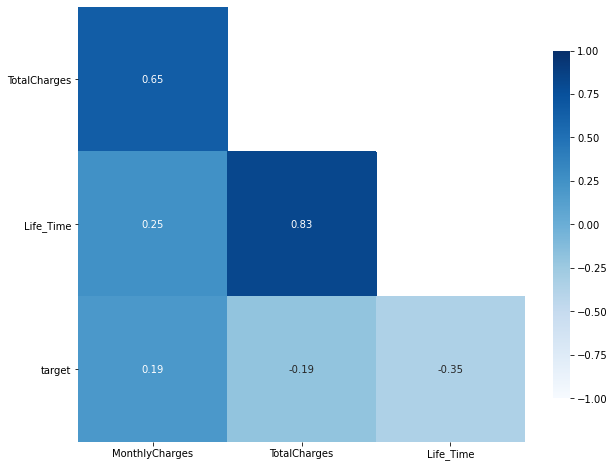

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(num_features_corr, dtype=np.bool))
mask = mask[1:, :-1]
corr = num_features_corr.iloc[1:,:-1].copy()
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
plt.yticks(rotation=0)
plt.show()

Видим, что признак TotalCharges сильно коррелирует с признаком Life_Time. При этом корреляция между целевым признаком и Life_Time сильнее, чем между целевым признаком и TotalCharges.

Поэтому можем удалить признак TotalCharges из набора данных.

In [43]:
features_train.drop('TotalCharges', axis=1, inplace=True)
features_test.drop('TotalCharges', axis=1, inplace=True)

# Выводы по этапу 2.

На данном этапе мы соединили имеющиеся данные в единую аналитическую таблицу, обработали пропущенные значения, возникшие в ходе соединения таблиц, провели преобразование типов данных, создали новые признаки и избавились от ненужных. Также мы разделили набор данных на тренировочную и тестовую выборки, закодировали категориальные переменные и нормировали количественные переменные. Кроме того, был проведён корреляционный анализ признаков на предмет наличия мультиколлинеарности. По итогу анализа было принято решение об удалении признака TotalCharges, так как он сильно коррелирует с признаком Life_Time, который в свою очередь сильнее коррелирует с целевым признаком, чем признак TotalCharges.

<a href='#title'>К оглавлению.</a>

# Этап 3. Подбор оптимальной модели и её гиперпараметров, оценка качества работы модели на отложенной выборке.

На данном этапе будут опробованы различные алгоритмы машинного обучения, для каждого из них будет подобран оптимальный набор гиперпараметров с оценкой точности работы алгоритма на валидационной выборке. Работа алгоритма, показавшего наибольшее значение оптимизируемой метрики на валидационных данных, будет протестирована на отложенной выборке.

Оптимизируемой метрикой будет ROC-AUC, дополнительно для каждого алгоритма будем оценивать метрику Accuracy. 

Исследуем алгоритмы RandomForestClassifier, LogisticRegression, CatBoostClassifier и LGBMClassifier.

<a id='3.1'></a>
## Этап 3.1. RandomForestClassifier.

Начнём с алгоритма RandomForestClassifier.

Для модели LogisticRegression будем оптимизировать гиперпараметры количества деревьев (n_estimators) и глубину одного дерева (max_depth).

Для поиска оптимального набора гиперпараметров используем алгоритм GridSearchCV.

Метрикой эффективности алгоритма будет ROC-AUC, для проверки точности моделей будем использовать встроенный механизм кросс-валидации на 10 фолдах. Для ускорения обучения моделей задействуем все ядра процессора с помощью прааметра n_jobs с аргументом -1.

In [44]:
model = RandomForestClassifier(random_state=42)
params = {
    'n_estimators' : [i for i in range(1, 101, 5)],
    'max_depth' : [i for i in range(1, 20, 1)]
}

gs = GridSearchCV(model, params, scoring='roc_auc', cv=10, verbose=True, n_jobs=-1)
gs.fit(features_train, target_train)
print('Лучшее значение ROC-AUC: {:.4f}'.format(gs.best_score_))
print('Лучшие значения гиперпараметров модели: {}'.format(gs.best_params_))

Fitting 10 folds for each of 380 candidates, totalling 3800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   54.8s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 3800 out of 3800 | elapsed:  3.2min finished


Лучшее значение ROC-AUC: 0.8549
Лучшие значения гиперпараметров модели: {'max_depth': 7, 'n_estimators': 46}


Оптимального значения метрики ROC-AUC в размере 0.8549 удалось достичь при следующих гиперпараметрах: max_depth - 7, n_estimators -  46.

Обучим финальную модель на указанных значения гиперпараметров и протестируем её работу на тестовой выборке.

In [45]:
model = RandomForestClassifier(random_state=42, n_estimators=gs.best_params_['n_estimators'], 
                               max_depth=gs.best_params_['max_depth'])
model.fit(features_train, target_train)
print('ROC-AUC на отложенной выборке для RandomForestClassifier: {:.4f}'.format(roc_auc_score(target_test, 
                                                                   model.predict_proba(features_test)[:, 1])))
print('Accuracy на отложенной выборке для RandomForestClassifier: {:.4f}'.format(accuracy_score(target_test, 
                                                                   model.predict(features_test))))

ROC-AUC на отложенной выборке для RandomForestClassifier: 0.8785
Accuracy на отложенной выборке для RandomForestClassifier: 0.8240


Модель RandomForestClassifier при оптимальных значениях гиперпараметров обеспечивает ROC-AUC на уровне 0.8785, а Accuracy - на уровне 0.8240.

Посмотрим на то, какие признаки модель посчитала важными, а какие определила как незначимые. 

Для этого воспользуемся методом feature_importances_.

С помощью него посмотрим на важность признаков, результаты представим в виде нового DataFrame.

In [46]:
feature_importances = pd.DataFrame({'feature' : features_train.columns, 
            'importance' : model.feature_importances_}).sort_values('importance', ascending=False)

Визуализируем результаты в виде горизонтальной гистограммы.

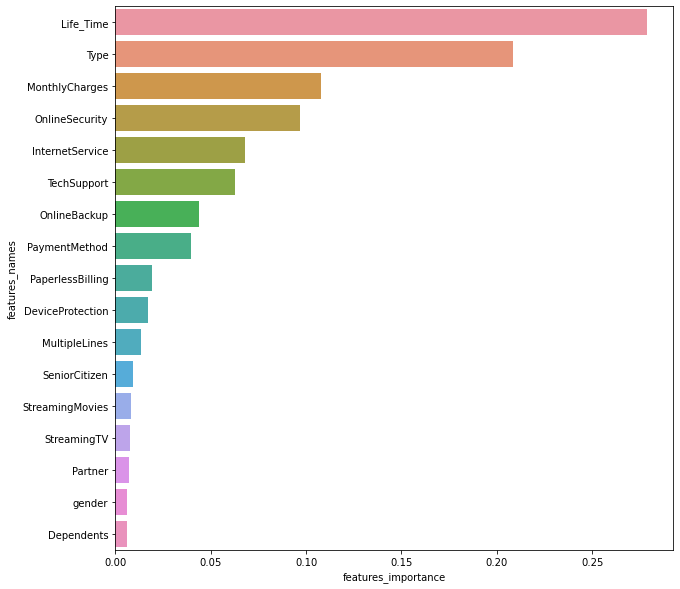

In [47]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x='importance', y='feature', data=feature_importances)
ax.set_xlabel('features_importance')
ax.set_ylabel('features_names');

Как видим, наиболее значимым оказался признак длительности жизни клиента в компании. Следом за ним идут признаки длительности подписки, месячная плата и др. 

Условимся, что признак считается важным, если уровень его значимости выше или равен 0.05.

Посмотрим, какие признаки являются важными, а какие - нет.

In [48]:
print('Важные признаки:', *list(feature_importances[feature_importances['importance'] >= 0.05]['feature']))
print('Неважные признаки:', *list(feature_importances[feature_importances['importance'] < 0.05]['feature']))

Важные признаки: Life_Time Type MonthlyCharges OnlineSecurity InternetService TechSupport
Неважные признаки: OnlineBackup PaymentMethod PaperlessBilling DeviceProtection MultipleLines SeniorCitizen StreamingMovies StreamingTV Partner gender Dependents


Избавимся от неважных признаков в тренировочной и тестовой выборках.

In [49]:
imp_features = list(feature_importances[feature_importances['importance'] >= 0.05]['feature'])
features_train = features_train[imp_features]
features_test = features_test[imp_features]

Протестируем работу модели с новым набором признаков.

In [50]:
model = RandomForestClassifier(random_state=42)
params = {
    'n_estimators' : [i for i in range(1, 101, 5)],
    'max_depth' : [i for i in range(1, 20, 1)]
}

gs = GridSearchCV(model, params, scoring='roc_auc', cv=10, verbose=True, n_jobs=-1)
gs.fit(features_train, target_train)
print('Лучшее значение ROC-AUC: {:.4f}'.format(gs.best_score_))
print('Лучшие значения гиперпараметров модели: {}'.format(gs.best_params_))

Fitting 10 folds for each of 380 candidates, totalling 3800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 860 tasks      | elapsed:   33.9s
[Parallel(n_jobs=-1)]: Done 1310 tasks      | elapsed:   56.8s
[Parallel(n_jobs=-1)]: Done 1860 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 2510 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3260 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 3800 out of 3800 | elapsed:  4.5min finished


Лучшее значение ROC-AUC: 0.8587
Лучшие значения гиперпараметров модели: {'max_depth': 8, 'n_estimators': 96}


Оптимального значения метрики ROC-AUC в размере 0.8587 удалось достичь при следующих гиперпараметрах: max_depth - 8, n_estimators -  96.

Обучим финальную модель на указанных значения гиперпараметров и протестируем её работу на тестовой выборке.

In [51]:
model = RandomForestClassifier(random_state=42, n_estimators=gs.best_params_['n_estimators'], 
                               max_depth=gs.best_params_['max_depth'])
model.fit(features_train, target_train)
print('ROC-AUC на отложенной выборке для RandomForestClassifier: {:.4f}'.format(roc_auc_score(target_test, 
                                                                   model.predict_proba(features_test)[:, 1])))
print('Accuracy на отложенной выборке для RandomForestClassifier: {:.4f}'.format(accuracy_score(target_test, 
                                                                   model.predict(features_test))))

ROC-AUC на отложенной выборке для RandomForestClassifier: 0.8798
Accuracy на отложенной выборке для RandomForestClassifier: 0.8346


Модель RandomForestClassifier при оптимальных значениях гиперпараметров обеспечивает ROC-AUC на уровне 0.8798, а Accuracy - на уровне 0.8346.

В целом это кажется неплохим результатом, однако протестируем и другие алгоритмы.

<a href='#title'>К оглавлению.</a>

<a id='3.2'></a>
## Этап 3.2. LogisticRegression.

Протестируем алгоритм LogisticRegression.

Алгоритм LogisticRegression является линейным, поэтому легко обучается. Кроме того, он не склонен к переобучению и не имеет большое количество гиперпараметров.

Для модели LogisticRegression будем оптимизировать гиперпараметры силы регуляризации (С), баланса типов регуляризации (l1_ratio) и баланс классов целевого признака (class_weight).

In [52]:
model = LogisticRegression(random_state=42)
params = {
    'C' : np.logspace(-4, 4, 20),
    'l1_ratio' : np.arange(0, 1.1, 0.1),
    'class_weight' : ['balanced', None]
}

gs = GridSearchCV(model, params, scoring='roc_auc', cv=10, verbose=True, n_jobs=-1)
gs.fit(features_train, target_train)
print('Лучшее значение ROC-AUC: {:.4f}'.format(gs.best_score_))
print('Лучшие значения гиперпараметров модели: {}'.format(gs.best_params_))

Fitting 10 folds for each of 440 candidates, totalling 4400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 1528 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 2428 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 3528 tasks      | elapsed:   29.8s


Лучшее значение ROC-AUC: 0.8315
Лучшие значения гиперпараметров модели: {'C': 0.08858667904100823, 'class_weight': 'balanced', 'l1_ratio': 0.0}


[Parallel(n_jobs=-1)]: Done 4400 out of 4400 | elapsed:   36.7s finished


Оптимального значения метрики ROC-AUC в размере 0.8315 удалось достичь при следующих гиперпараметрах: С - 0.08858667904100823, class_weight -  balanced, l1_ratio -  0.0.

Обучим финальную модель на указанных значения гиперпараметров и протестируем её работу на тестовой выборке.

In [53]:
model = LogisticRegression(random_state=42, C = gs.best_params_['C'], 
                           class_weight = gs.best_params_['class_weight'],
                          l1_ratio = gs.best_params_['l1_ratio'])
model.fit(features_train, target_train)
print('ROC-AUC на отложенной выборке для LogisticRegression: {:.4f}'.format(roc_auc_score(target_test, 
                                                                   model.predict_proba(features_test)[:, 1])))
print('Accuracy на отложенной выборке для LogisticRegression: {:.4f}'.format(accuracy_score(target_test, 
                                                                   model.predict(features_test))))

ROC-AUC на отложенной выборке для LogisticRegression: 0.8535
Accuracy на отложенной выборке для LogisticRegression: 0.7544


Модель LogisticRegression при оптимальных гиперпараметрах обеспечивает ROC-AUC на уровне 0.8535, а Accuracy - на уровне 0.7544.

В целом это кажется неплохим результатом, однако протестируем и другие алгоритмы.

<a href='#title'>К оглавлению.</a>

<a id='3.3'></a>
## Этап 3.3. CatBoostClassifier.

CatBoostClassifier подбирает гиперпараметры автоматически, поэтому GridSearchCV использовать не будем. В качестве функции потерь используем CrossEntropy, так как мы решаем задачу бинарной классификации. Количество итераций ограничим на двух тысячах. Также укажем модели перечень категориальных признаков.

In [54]:
cat_features = ['Type', 'OnlineSecurity', 'InternetService', 'TechSupport']

In [55]:
model = CatBoostClassifier(loss_function='CrossEntropy', iterations=2000, random_state=42)
model.fit(features_train, target_train, cat_features=cat_features, verbose=0)
print('ROC-AUC на отложенной выборке для CatBoostClassifier: {:.4f}'.format(roc_auc_score(target_test, 
                                                                   model.predict_proba(features_test)[:, 1])))
print('Accuracy на отложенной выборке для CatBoostClassifier: {:.4f}'.format(accuracy_score(target_test, 
                                                                   model.predict(features_test))))

ROC-AUC на отложенной выборке для CatBoostClassifier: 0.9468
Accuracy на отложенной выборке для CatBoostClassifier: 0.8964


Модель CatBoostClassifier обеспечивает ROC-AUC на уровне 0.9468, а Accuracy - на уровне 0.8964.

Этот результат значительно лучше результата, который обеспечила модель LogisticRegression и RandomForestClassifier. Однако посмотрим на другие алгоритмы.

<a href='#title'>К оглавлению.</a>

<a id='3.4'></a>
## Этап 3.4. LGBMClassifier.

Последний алгоритм - LGBMClassifier.

Для поиска оптимального набора гиперпараметров используем GridSearchCV с валидацией на 10 фолдах и использованием всех ядер процессора. Количество дереьвев установим на уровне 800, для ускорения обучения модели для каждого дерева будем брать 0.7 от всех признаков и наблюдений, доступных для обучения. Однако отметим, что в силу принципа бутстрапа, заложенного в LGBMClassifier, в обучении так или иначе поучаствуют все признаки и наблюдения.

In [56]:
model = LGBMClassifier(n_estimators=800, colsample_bytree=0.7, subsample=0.7)
grid_params = {
    'learning_rate' : [round(i,2) for i in np.arange(0.01, 0.21, 0.010)],
    'num_leaves' : [i for i in range(1, 52, 5)]
}
gs = GridSearchCV(model, grid_params, scoring='roc_auc', cv=10, verbose=True, n_jobs=-1)
gs.fit(features_train, target_train, categorical_feature = cat_features, verbose=10)
print('Лучшее значение ROC-AUC: {:.4f}'.format(gs.best_score_))
print('Лучшие значения гиперпараметров модели: {}'.format(gs.best_params_))

Fitting 10 folds for each of 220 candidates, totalling 2200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 2200 out of 2200 | elapsed:  5.2min finished


Лучшее значение ROC-AUC: 0.9220
Лучшие значения гиперпараметров модели: {'learning_rate': 0.2, 'num_leaves': 6}


Оптимального значения метрики ROC-AUC в размере 0.9220 удалось достичь при следующих гиперпараметрах: learning_rate - 0.2, num_leaves -  6.

Обучим финальную модель на указанных значения гиперпараметров и протестируем её работу на тестовой выборке.

In [57]:
model = LGBMClassifier(n_estimators=800, colsample_bytree=0.7, subsample=0.7, 
                       learning_rate=gs.best_params_['learning_rate'],
                      num_leaves=gs.best_params_['num_leaves'])
model.fit(features_train, target_train, categorical_feature = cat_features)
print('ROC-AUC на отложенной выборке для LGBMClassifier: {:.4f}'.format(roc_auc_score(target_test, 
                                                                   model.predict_proba(features_test)[:, 1])))
print('Accuracy на отложенной выборке для LGBMClassifier: {:.4f}'.format(accuracy_score(target_test, 
                                                                   model.predict(features_test))))

ROC-AUC на отложенной выборке для LGBMClassifier: 0.9437
Accuracy на отложенной выборке для LGBMClassifier: 0.8850


Модель LGBMClassifier при оптимальных значениях гиперпараметров обеспечивает ROC-AUC на уровне 0.9437, а Accuracy - на уровне 0.8850.

Этот результат значительно лучше результата, который обеспечила модель LogisticRegression, однако несколько хуже результатов модели CatBoostClassifier.

<a id='3.5'></a>
## Этап 3.5. Анализ лучшей модели.

Модель CatBoostClassifier является лучшей из рассмотренных: она обеспечивает ROC-AUC на уровне 0.9468, а Accuracy - на уровне 0.8964.

Рассмотрим работу этой модели более подробно.

Для начала выясним, сбалансированы ли классы в целевом признаке.

In [58]:
personal['target'].value_counts()

0    5174
1    1869
Name: target, dtype: int64

Видим, что мы имеем дело с явным дисбалансом классов: в значительной мере в выборке содержатся клиенты, которые не уходили из компании, поэтому их модель и будет предсказывать чаще всего.

Построим матрицу ошибок, чтобы понять, где модель ошибается чаще всего.

In [59]:
model = CatBoostClassifier(loss_function='CrossEntropy', iterations=2000, random_state=42)
model.fit(features_train, target_train, cat_features=cat_features, verbose=0)
predictions_test = model.predict(features_test)
confusion_matrix_catboost = confusion_matrix(target_test, predictions_test)
confusion_matrix_catboost

array([[1014,   22],
       [ 124,  249]])

Рассчитаем и выведем на экран метрики качества классификации.

In [60]:
TP = confusion_matrix_catboost[1][1]
TN = confusion_matrix_catboost[0][0]
FP = confusion_matrix_catboost[0][1]
FN = confusion_matrix_catboost[1][0]

print('TP:', TP)
print('TN:', TN)
print('FP:', FP)
print('FN:', FN)

TP: 249
TN: 1014
FP: 22
FN: 124


Дадим интерпретацию этим значениям:

1. TP = 249. Следовательно, модель предсказала уход клиента, который действительно ушёл, 249 раз.

2. TN = 1 014. Следовательно, модель предсказала сохранение клиента, который действительно не ушёл, 1 014 раз.

3. FP = 22. Следовательно, модель совершила ошибку первого рода - предсказала уход клиента, который в действительности не ушёл - 22 раза.

4. FN = 124. Следовательно, модель совершила ошибку второго рода - предсказала сохранение клиента, который в действительности ушёл - 124 раза.

Рассчитаем метрики precision и recall.

In [62]:
print('Метрика precision:', round(precision_score(target_test, predictions_test), 4))
print('Метрика recall:', round(recall_score(target_test, predictions_test), 4))

Метрика precision: 0.9188
Метрика recall: 0.6676


Сделаем некоторые выводы о построенной модели:

1. Исходя из анализа матрицы ошибок, можно заключить, модель предсказывает класс 1 (отток) лучше, чем класс 0 (не отток). Это находит своё отражение в том, что модель совершает меньше ошибок первого рода (предсказывая уход клиента тогда, когда он в действительно сохраняется), чем ошибок второго рода (предсказывая сохранение клиента, в то время как в действительности клиент уходит).


2. Метрика recall сложилась на уровне 0.6676. Следовательно, из всех действительно ушедших клиентов, которых модель смогла определить корректно, а также тех клиентов, которые ушли и которых модель определить не смогла, совершив ошибку второго рода (TP + FN, что составляет 373 клиентоа), модель смогла правильно определить только около 66%, что является довольно неплохим результатом.


3. Метрика precision сложилась на уровне 0.9188. Следовательно, из всех действительно ушедших клиентов, которых модель смогла определить, а также среди тех клиентов, которые на самом деле не ушли и уход которых модель предсказала, совершив ошибку первого рода (TP + FP, что составляет 271 клиент), модель смогла правильно определить около 92%. Неплохое значение метрики обусловленно небольшим количеством ошибок первого рода - модель достаточно хорошо предсказывает уход клиента, но чаще ошибается с предсказанием клиентов, которые не уходят.

Резюмируя, можно отметить, модель реже ошибается в предсказании ухода клиента (небольшое количество клиентов было отмечено как сохранённые, однако в действительности они ушли, т.е больше ошибок второго рода), чем в предсказании сохранения клиента (большее количество клиентов было отмечено как ушедшие, которые в действительности остались в компании, т.е. меньше ошибок первого рода). 

Рассчитаем такие метрики, как True Positive Rate и False Positive Rate.

In [63]:
print('TPR:', round((TP / (TP + FN)), 4))
print('FPR:', round((FP / (FP + TN)), 4))

TPR: 0.6676
FPR: 0.0212


Метрика TPR сложилась на уровне 0.6676. Следовательно, в 67% случаев построенная модель будет успешно предсказывать объекты с классом 1 (уход клиента), что кажется довольно приятным результатом.

Метрика FPR сложилась на уровне 0.0212. Следовательно, только в 2% случаев построенная модель может ошибаться, предсказывая сохранение клиента. Следовательно, в 98% случаев модель успешно предскажет сохранение клиента.

В случае предсказания моделью не класса объекта, а вероятности отнесения объекта к тому или иному классу, отнесение объекта к классу будет зависеть от порога классификации. По умолчанию он установлен на уровне 0.5. Однако интерес представляет ситуация, при которой порог классификации будет смещаться в ту или иную сторону.

Чтобы узнать, как будут меняться метрики TPR и FPR при изменении порога классификации, построим ROC-кривую.

In [64]:
proba_test = model.predict_proba(features_test)

Посмотрим, что получилось.

In [65]:
proba_test

array([[0.51713874, 0.48286126],
       [0.9364423 , 0.0635577 ],
       [0.98678357, 0.01321643],
       ...,
       [0.98928684, 0.01071316],
       [0.99102575, 0.00897425],
       [0.42699174, 0.57300826]])

На выходе имеем массив с двумя колонками: в первой колонке приведена вероятность отнесения клиента к классу 0, во второй колонке - вероятность отнесения клиента к классу 1.

Для построения ROC-кривой нам нужны вероятности отнесения к классу 1. Обозначим их как отдельную переменную.

In [66]:
proba_test_one = proba_test[:, 1]

Можно приступить к построению ROC-кривой.

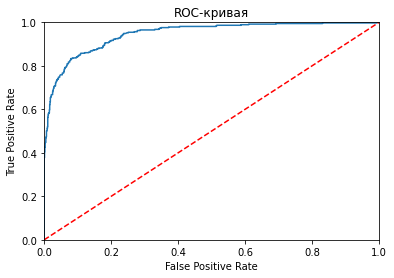

In [67]:
fpr, tpr, thresholds = roc_curve(target_test, proba_test_one)

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Из графика видно, что по мере роста порога классификации TPR и FPR увеличиваются: при увеличении порога классификации модель будет чаще относить объект к классу 1, следовательно, увеличится количество TP (верно предсказанных уходов) и FP (ложно предсказанных уходов). 

При установлении порога классификации на уровне 1 модель будет относить объекты только к классу 1 (т.е. предсказывать только уход).

Чтобы понять, насколько хорошо построенная модель будет предсказывать уход клиента, нкжно посчтитать площадь под ROC-кривой, т.е. метрику ROC-AUC.

In [68]:
print('ROC-AUC на отложенной выборке для CatBoostClassifier: {:.4f}'.format(roc_auc_score(target_test, 
                                                                   model.predict_proba(features_test)[:, 1])))

ROC-AUC на отложенной выборке для CatBoostClassifier: 0.9468


Чтобы оценить качество построенной модели по метрике ROC-AUC, достаточно сравнить значение метрики ROC-AUC, рассчитанное для построенной модели, с значением метрики ROC-AUC, равное 0,50. Именно такое значение метрики ROC-AUC обеспечивает случайный классификатор.

Убедимся в этом на практике.

Создадим набор данных из случайных вероятностей отнесения клиента к классу 1 в размере, соответствующем размеру тестового набора данных.

In [69]:
random_predict_proba = pd.Series(random() for i in range(len(target_test)))

Рассчитаем значение ROC-AUC для случайного классификатора.

In [70]:
print('ROC-AUC для случайного классификатора:', round(roc_auc_score(target_test, random_predict_proba), 4))

ROC-AUC для случайного классификатора: 0.495


Видим, что для случайного классификатора метрика ROC-AUC составляет около 0.50. В целом, это кажется логичным и находит своё продолжение в законе больших чисел: чем чаще повторяем эксперимент, тем сильнее частота события (в данном случае - предсказание вероятности отнесения объекта к классу 1) приближается к вероятности её возникновения (при использовании случайного классификатора объект может быть отнесён к классу 1 с вероятностью в 50%).

Так как значение метрики ROC-AUC для построенной модели выше 0.50 (сложилось на уровне 0.9388), можно говорить о том, что построенная модель обеспечивает лучшее по сравнению со случайным классификатором значение метрик TPR и FPR и в целом предсказывает уход клиентов достаточно хорошо, так как допускает не слишком много много ошибок первого и второго рода.

Дополнительно требовалось рассчитать метрику Accuracy.

In [71]:
print('Accuracy на отложенной выборке для CatBoostClassifier: {:.4f}'.format(accuracy_score(target_test, 
                                                                   model.predict(features_test))))

Accuracy на отложенной выборке для CatBoostClassifier: 0.8964


Метрика Accuracy сложилась на уровне 0.8914. Следовательно, в 89% случаев модель предсказывает верные объекты классов целевого признака, то есть в целом на 89% верно предсказывает отток клиентов.

Проверим модель на адекватность с точки зрения метрики Accuracy.

Для сравнения построенной модели со случайной моделью создадим генератор случайных предсказаний, который будет в случайном порядке возвращать какой-либо класс объекта - 0 или 1 - в количестве, равном количеству объектов в тестовой выборке. 

In [72]:
random_predict = pd.Series(randint(0, 1) for i in range(len(target_test)))

Видим, что мы успешно создали набор данных со случайными предсказаниями класса целевого признака.

На основе полученных предсказаний рассчитаем метрику Accuracy.

In [73]:
print('Accuracy для случайной модели:', round((accuracy_score(target_test, random_predict)), 4))

Accuracy для случайной модели: 0.506


Видим, что случайная модель предсказывает класс целевого признака хуже построенной модели.

Ещё один тест на адекватность построенной модели - сравнение построенной модели с константной моделью. 

Для сравнения построенной модели с константной моделью создадим генератор константных предсказаний, который будет возвращать единственный класс - класс 1 или 0 - в количестве, равном количеству объектов в тестовой выборке. 

In [74]:
constant_predict_one = pd.Series(1 for i in range(len(target_test)))
constant_predict_zero = pd.Series(0 for i in range(len(target_test)))

Видим, что мы успешно создали набор данных с константными предсказаниями класса целевого признака.

На основе полученных предсказаний рассчитаем метрику Accuracy.

In [75]:
print('Accuracy для константной модели (класс 1):', round((accuracy_score(target_test, 
                                                                          constant_predict_one)), 4))
print('Accuracy для константной модели (класс 0):', round((accuracy_score(target_test, 
                                                                          constant_predict_zero)), 4))

Accuracy для константной модели (класс 1): 0.2647
Accuracy для константной модели (класс 0): 0.7353


Видим, что константная модель также хуже предсказывает класс целевого признака, чем построенная модель.

Таким образом, построенная модель может быть рекомендована компании «Ниединогоразрыва.ком» в качестве оптимальной модели, которая достаточно хорошо предсказывает отток клиентов, делая немногочисленные ошибки первого и второго рода, и которая не требует длительного времени на обучение относительно других алгоритмов.

# Выводы по этапу 3. 

На данном этапе мы опробовали различные алгоритмы машинного обучения для предсказания оттока клиентов из компании, для каждого алгоритма подобрали оптимальные гиперпараметры и протестировали их на отложенной выборке. Работу оптимальной модели проанализировали более подробно, рассчитав другие метрики классификации, построив матрицу ошибок, ROC-кривую и сравнив её работу с случайным и константным классификатором.

<a href='#title'>К оглавлению.</a>

# Этап 4. Подготовка отчёта для руководства компании.

<a id='4.1'></a>
## Этап 4.1. Подготовка отчёта для руководства компании.

На данном этапе тезисно обозначим достигнутые в ходе работы результаты.

В нашем распоряжении имелись сведения о:
- клиентах компании с некоторыми данными о них (пол, количество детей, наличие супруга/супруги, принадлежность к возрастной группе пенсионеров);
- информации о состоянии договоров клиентов и величины полученного от них дохода;
- информация о клиентах, пользующихся услугами телефонии;
- информация о клиентах, пользующихся услугами интернета и прочими услугами компании.

Основываясь на этих данных, требовалось построить модель, предсказывающую уход клиента из компании. Фактом ухода клиента является закрытие договора на сотрудничество с компанией.

Бизнес-ценность от данного решения заключается в предложении клиенту, намеревающемуся прекратить сотрудничество с компанией, скидок на услуги или бесплатную услугу для его удержания и сохранения оптимального объёма клиентской базы.

Для решения задачи был предложен следующий план работ:

1. Разведывательный анализ данных.

2. Предобработка данных и генерация новых признаков.

3. Подбор оптимальной модели и её гиперпараметров, оценка качества работы модели на отложенной выборке.

4. Подготовка отчёта для руководства компании.

На этапе разведывательного анализа данных мы провели первичное знакомство с данными, исследовали наборы данных на предмет количества признаков/объектов, типов данных, наличия дефектов в данных (пропуски/дубликаты и прочее), а также наметили некоторые направления предобработки данных.

На этапе предобработки данных и создания новых признаков все данные были собраны в единую аналитическую таблицу, образовывашиеся при этом пропуски были эмпирически заменены на признак отсутствия у клиента той или иной услуги в целях недопущения искажения бизнес-логики в данных.

Далее были выполнены требуемые преобразования данных (в дату из строчного, в численный из строчного и др.), заменены отсутствующие значения в дате окончания договора на дату формирования выборки, в явном виде определён целевой признак. 

С помощью признаков даты начала и окончания сотрудничества клиента с компанией был рассчитан новый признак длительности жизни клиента в компании, ненужные признаки были удалены из набора данных. 

Также были выявлены 11 клиентов с длительностью контракта, равной нулю, для которых признак TotalCharges принимал пустое значение. Такие неявные пропуски были заменены нулями, так как эти клиенты заключили свои договоры с компанией в день формирования выгрузки и ещё не успели внести первые платежи.

Далее набор данных был разделён на обучающую и тестовую выборки в соотношении 80/20.

После этого категориальные переменные были закодированы в числовом виде с помощью техники OrdinalEncoder, непрерывные численные признаки были нормированы с помощью техники  StandardScaler. 

Кроме того, был проведён корреляционный анализ признаков на предмет наличия мультиколлинеарности. По итогу анализа было принято решение об удалении признака TotalCharges из обучающей и тестовой выборок, так как он сильно коррелирует с признаком Life_Time, который в свою очередь сильнее коррелирует с целевым признаком, чем признак TotalCharges.

После этого были протестированы и сравнены между собой 4 алгоритма машинного обучения: RandomForestClassifier, LogisticRegression, CatBoostClassifier и LGBMClassifier. Критерием эффективности моделей была метрика ROC-AUC, дополнительно для каждой модели была рассчитана метрика Accuracy. 

На этапе моделирования был произведён отбор признаков по степени их важности относительно целевого признака с помощью feature_importances_. Перед отбором признаков мы условились, что значимым будет считаться признак, чья важность в модели равна или выше 0.05.

К значимым признакам в модели были отнесены: Life_Time, Type, MonthlyCharges, OnlineSecurity, InternetService, TechSupport.

К незначимым признакам были отнесены: OnlineBackup, PaymentMethod, PaperlessBilling, DeviceProtection, MultipleLines, SeniorCitizen, StreamingMovies, StreamingTV, Partner, gender, Dependents.

В обучении финальных версий алгоритмов участвовали только значимые признаки.

Отметим результаты работы моделей:

- RandomForestClassifier: ROC-AUC на уровне 0.8798, Accuracy - на уровне 0.8346.
- LogisticRegression: ROC-AUC на уровне 0.8535, Accuracy - на уровне 0.7544.
- **CatBoostClassifier: ROC-AUC на уровне 0.9468, Accuracy - на уровне 0.8964**.
- LGBMClassifier: ROC-AUC на уровне 0.9437, Accuracy - на уровне 0.8850.

Лучший результат продемонстрировала модель CatBoostClassifier - ROC-AUC на уровне 0.9468, Accuracy - на уровне 0.8964. 

Результаты её работы были протестированы более детально с помощью других метрик классификации, матрицы ошибок, ROC-кривой, а также сравнением с случайной и константными моделями. Отметим некоторые результаты:


1. Количество истинноположительных ответов = 249. Следовательно, модель предсказала уход клиента, который действительно ушёл, 249 раз.


2. Количество истинноотрицательных ответов = 1 014. Следовательно, модель предсказала сохранение клиента, который действительно не ушёл, 1 014 раз.


3. Количество ложноположительных ответов = 22. Следовательно, модель совершила ошибку первого рода - предсказала уход клиента, который в действительности не ушёл - 22 раза.


4. Количество ложиноотрицательных ответов = 124. Следовательно, модель совершила ошибку второго рода - предсказала сохранение клиента, который в действительности ушёл - 124 раза.


5. Исходя из анализа матрицы ошибок, можно заключить, модель предсказывает класс 1 (отток) лучше, чем класс 0 (не отток). Это находит своё отражение в том, что модель совершает меньше ошибок первого рода (предсказывая уход клиента тогда, когда он в действительно сохраняется), чем ошибок второго рода (предсказывая сохранение клиента, в то время как в действительности клиент уходит). Такой результат сложился из-за дисбаланса классов: в данных значительно больше клиентов, которые не ушли в отток, чем клиентов, которые покинули компанию.


6. Метрика recall сложилась на уровне 0.6676. Следовательно, из всех действительно ушедших клиентов, которых модель смогла определить корректно, а также тех клиентов, которые ушли и которых модель определить не смогла, совершив ошибку второго рода (373 клиента), модель смогла правильно определить только около 66%, что является довольно неплохим результатом.


7. Метрика precision сложилась на уровне 0.9188. Следовательно, из всех действительно ушедших клиентов, которых модель смогла определить, а также среди тех клиентов, которые на самом деле не ушли и уход которых модель предсказала, совершив ошибку первого рода (271 клиент), модель смогла правильно определить около 92%. Неплохое значение метрики обусловленно небольшим количеством ошибок первого рода - модель достаточно хорошо предсказывает уход клиента, но чаще ошибается с предсказанием клиентов, которые не уходят.


8. Метрика TPR (доля истинноположительных ответов) сложилась на уровне 0.6676. Следовательно, в 67% случаев построенная модель будет успешно предсказывать объекты с классом 1 (уход клиента), что кажется довольно приятным результатом.


9. Метрика FPR (доля ложноположительных ответов) сложилась на уровне 0.0212. Следовательно, только в 2% случаев построенная модель может ошибаться, предсказывая сохранение клиента. Следовательно, в 98% случаев модель успешно предскажет сохранение клиента.


10. ROC-AUC для случайного классификатора - 0.4950, ROC-AUC на отложенной выборке для CatBoostClassifier - 0.9468. Построенная модель обеспечивает лучшее по сравнению со случайным классификатором значение метрик TPR и FPR и в целом предсказывает уход клиентов достаточно хорошо, так как допускает не слишком много много ошибок первого и второго рода.


11. Accuracy для случайной модели - 0.5060, Accuracy для константной модели (класс 1) - 0.2647, Accuracy для константной модели (класс 0) - 0.7353, Accuracy на отложенной выборке для CatBoostClassifier - 0.8964. Константная модель также хуже предсказывает класс целевого признака, чем построенная модель.


Таким образом, построенная модель модель CatBoostClassifier с значениями метрик ROC-AUC на уровне 0.9468, Accuracy на уровне 0.8964. может быть рекомендована компании «Ниединогоразрыва.ком» в качестве оптимальной модели, которая достаточно хорошо предсказывает отток клиентов, делая немногочисленные ошибки первого и второго рода, и которая не требует длительного времени на обучение относительно других алгоритмов.

<a href='#title'>К оглавлению.</a>